## Import Modules & Set-Up

In [534]:
# basic
import pandas as pd
import numpy as np
import xgboost as xgb

# viz
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
# import graphviz

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, roc_auc_score, roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

# custom config
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [535]:
# MPL Settings
%config InlineBackend.figure_format = 'svg'

mpl.rcParams["font.family"] = "Arial"
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams["figure.figsize"] = [10, 8]
%matplotlib inline

grey = '#808080'
darkgrey = '#505050'
# (http://www.color-hex.com/color/505050)

mpl.rcParams['axes.linewidth'] = 0.3
mpl.rcParams['axes.edgecolor'] = grey
mpl.rcParams['xtick.color'] = grey
mpl.rcParams['ytick.color'] = grey
mpl.rcParams['text.color'] = darkgrey
mpl.rcParams['axes.labelcolor'] = darkgrey

In [536]:
csv_loc = 'https://www.kaggle.com/HRAnalyticRepository/employee-attrition-data#:~:text=calendar_view_week-,MFG10YearTerminationData,-.csv'

In [537]:
df = pd.read_csv('MFG10YearTerminationData.csv', parse_dates=[ 
    'recorddate_key',
 'birthdate_key',
 'orighiredate_key',
 'terminationdate_key',])
df.shape
df.dtypes
df.head(10)


(49653, 18)

EmployeeID                      int64
recorddate_key         datetime64[ns]
birthdate_key          datetime64[ns]
orighiredate_key       datetime64[ns]
terminationdate_key    datetime64[ns]
age                             int64
length_of_service               int64
city_name                      object
department_name                object
job_title                      object
store_name                      int64
gender_short                   object
gender_full                    object
termreason_desc                object
termtype_desc                  object
STATUS_YEAR                     int64
STATUS                         object
BUSINESS_UNIT                  object
dtype: object

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
0,1318,2006-12-31,1954-01-03,1989-08-28,1900-01-01,52,17,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2006,ACTIVE,HEADOFFICE
1,1318,2007-12-31,1954-01-03,1989-08-28,1900-01-01,53,18,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2007,ACTIVE,HEADOFFICE
2,1318,2008-12-31,1954-01-03,1989-08-28,1900-01-01,54,19,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2008,ACTIVE,HEADOFFICE
3,1318,2009-12-31,1954-01-03,1989-08-28,1900-01-01,55,20,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2009,ACTIVE,HEADOFFICE
4,1318,2010-12-31,1954-01-03,1989-08-28,1900-01-01,56,21,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2010,ACTIVE,HEADOFFICE
5,1318,2011-12-31,1954-01-03,1989-08-28,1900-01-01,57,22,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2011,ACTIVE,HEADOFFICE
6,1318,2012-12-31,1954-01-03,1989-08-28,1900-01-01,58,23,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2012,ACTIVE,HEADOFFICE
7,1318,2013-12-31,1954-01-03,1989-08-28,1900-01-01,59,24,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2013,ACTIVE,HEADOFFICE
8,1318,2014-12-31,1954-01-03,1989-08-28,1900-01-01,60,25,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2014,ACTIVE,HEADOFFICE
9,1318,2015-12-31,1954-01-03,1989-08-28,1900-01-01,61,26,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2015,ACTIVE,HEADOFFICE


## Exploratory Data Analysis & Feature Engineering

In [538]:
# Active vs Churned

df.EmployeeID.nunique()
df.STATUS.value_counts()

df.groupby(['termtype_desc', 'termreason_desc', ]).agg({'EmployeeID': ['nunique']})

6284

ACTIVE        48168
TERMINATED     1485
Name: STATUS, dtype: int64

EmployeeID
                                  nunique
termtype_desc  termreason_desc           
Involuntary    Layoff                 215
Not Applicable Not Applicable        6138
Voluntary      Resignaton             385
               Retirement             885

Since we only want to look at those employees who voluntarily left vs those who remained, it makes sense to exclude Retirements and Layoffs from the model.

In [539]:
# Removing Retirements and Layoffs
excl_emps = df.loc[df['termreason_desc'].isin(['Layoff', 'Retirement']), 'EmployeeID']
df = df[~df['EmployeeID'].isin(excl_emps)].copy()
# New count
df.EmployeeID.nunique()

5184

In [540]:
global_attr_rate = round((df[df.STATUS=='TERMINATED'].EmployeeID.nunique()/df.EmployeeID.nunique()), 3)
global_attr_rate

0.074

So employee attrition rate (voluntarily resigning employees) is ~7.4%

In [541]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
cols = list(df.columns)
cols

['employeeid',
 'recorddate_key',
 'birthdate_key',
 'orighiredate_key',
 'terminationdate_key',
 'age',
 'length_of_service',
 'city_name',
 'department_name',
 'job_title',
 'store_name',
 'gender_short',
 'gender_full',
 'termreason_desc',
 'termtype_desc',
 'status_year',
 'status',
 'business_unit']

In [542]:
categorical = cols.copy()

for i in ['employeeid', 'recorddate_key',
 'birthdate_key',
 'orighiredate_key',
 'terminationdate_key']:
    categorical.remove(i)

In [543]:
categorical
for c in categorical:
    f'value counts for {c}:' 
    df[c].value_counts()

['age',
 'length_of_service',
 'city_name',
 'department_name',
 'job_title',
 'store_name',
 'gender_short',
 'gender_full',
 'termreason_desc',
 'termtype_desc',
 'status_year',
 'status',
 'business_unit']

'value counts for age:'

50    1181
27    1178
51    1173
29    1172
28    1166
49    1162
53    1159
30    1158
52    1156
26    1156
35    1150
48    1147
34    1146
25    1144
47    1137
36    1136
54    1129
55    1125
46    1124
33    1121
44    1119
38    1118
42    1115
37    1115
43    1110
32    1106
45    1104
39    1102
41    1099
31    1095
40    1095
24    1066
56    1004
23     925
57     872
22     784
58     753
21     674
59     640
60     518
61     411
20     386
62     301
63     187
19     152
64      93
Name: age, dtype: int64

'value counts for length_of_service:'

3     2175
4     2170
5     2169
2     2153
6     2144
14    2140
13    2139
15    2129
9     2127
10    2124
1     2123
12    2122
11    2111
8     2094
7     2075
16    1943
0     1873
17    1780
18    1554
19    1333
20    1130
21     889
22     681
23     463
24     248
25      61
26      14
Name: length_of_service, dtype: int64

'value counts for city_name:'

Vancouver           10009
Victoria             4379
Nanaimo              3646
New Westminster      3029
Kelowna              2340
Burnaby              1948
Prince George        1908
Kamloops             1878
Cranbrook            1653
Surrey               1447
Richmond             1333
Chilliwack           1095
Terrace              1079
Trail                 844
Langley               842
Vernon                811
Squamish              732
Abbotsford            629
North Vancouver       622
Quesnel               615
Williams Lake         599
West Vancouver        551
Fort St John          545
Port Coquitlam        517
Aldergrove            471
Nelson                296
Bella Bella           121
New Westminister       12
Fort Nelson             9
Dawson Creek            3
Grand Forks             1
Name: city_name, dtype: int64

'value counts for department_name:'

Meats               8745
Dairy               7946
Bakery              7834
Produce             7074
Customer Service    6559
Processed Foods     5647
Executive            100
Store Management      47
Recruitment           10
HR Technology          2
Name: department_name, dtype: int64

'value counts for job_title:'

Meat Cutter                        8635
Dairy Person                       7946
Baker                              7714
Produce Clerk                      6954
Cashier                            6379
Shelf Stocker                      5481
Customer Service Manager            180
Processed Foods Manager             166
Bakery Manager                      120
Produce Manager                     120
Meats Manager                       110
Store Manager                        47
CEO                                  10
VP Stores                            10
Exec Assistant, Finance              10
Exec Assistant, Human Resources      10
CHief Information Officer            10
Exec Assistant, Legal Counsel        10
Exec Assistant, VP Stores            10
VP Finance                           10
VP Human Resources                   10
Legal Counsel                        10
Director, Recruitment                10
HRIS Analyst                          2
Name: job_title, dtype: int64

'value counts for store_name:'

46    4379
42    3762
18    3646
21    3029
43    2896
16    2340
5     1948
26    1908
15    1878
41    1710
8     1653
44    1520
31    1447
29    1333
6     1095
32    1079
33     844
17     842
36     811
30     732
1      629
22     622
28     615
40     599
38     551
12     545
25     517
2      471
19     296
35     121
3      121
20      12
11       9
9        3
13       1
Name: store_name, dtype: int64

'value counts for gender_short:'

M    22109
F    21855
Name: gender_short, dtype: int64

'value counts for gender_full:'

Male      22109
Female    21855
Name: gender_full, dtype: int64

'value counts for termreason_desc:'

Not Applicable    43579
Resignaton          385
Name: termreason_desc, dtype: int64

'value counts for termtype_desc:'

Not Applicable    43579
Voluntary           385
Name: termtype_desc, dtype: int64

'value counts for status_year:'

2013    4930
2014    4881
2015    4825
2012    4795
2011    4619
2010    4418
2009    4189
2008    3978
2007    3772
2006    3557
Name: status_year, dtype: int64

'value counts for status:'

ACTIVE        43579
TERMINATED      385
Name: status, dtype: int64

'value counts for business_unit:'

STORES        43852
HEADOFFICE      112
Name: business_unit, dtype: int64

In [544]:
term_emps = df.loc[df['status']=='TERMINATED', 'employeeid']
df[df['employeeid'].isin(term_emps)].sort_values(['employeeid', 'recorddate_key']).head(10)

,employeeid,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,status_year,status,business_unit
234,1365,2006-12-31,1949-03-24,1989-10-10,2012-09-26,57,17,Fort St John,Store Management,Store Manager,12,F,Female,Not Applicable,Not Applicable,2006,ACTIVE,STORES
235,1365,2007-12-31,1949-03-24,1989-10-10,2012-09-26,58,18,Fort St John,Store Management,Store Manager,12,F,Female,Not Applicable,Not Applicable,2007,ACTIVE,STORES
236,1365,2008-12-31,1949-03-24,1989-10-10,2012-09-26,59,19,Fort St John,Store Management,Store Manager,12,F,Female,Not Applicable,Not Applicable,2008,ACTIVE,STORES
237,1365,2009-12-31,1949-03-24,1989-10-10,2012-09-26,60,20,Fort St John,Store Management,Store Manager,12,F,Female,Not Applicable,Not Applicable,2009,ACTIVE,STORES
238,1365,2010-12-31,1949-03-24,1989-10-10,2012-09-26,61,21,Fort St John,Store Management,Store Manager,12,F,Female,Not Applicable,Not Applicable,2010,ACTIVE,STORES
239,1365,2011-12-31,1949-03-24,1989-10-10,2012-09-26,62,22,Fort St John,Store Management,Store Manager,12,F,Female,Not Applicable,Not Applicable,2011,ACTIVE,STORES
48186,1365,2012-09-01,1949-03-24,1989-10-10,2012-09-26,63,22,Fort St John,Store Management,Store Manager,12,F,Female,Resignaton,Voluntary,2012,TERMINATED,STORES
659,1484,2006-12-31,1949-11-22,1990-02-15,2007-07-25,57,16,Vancouver,HR Technology,HRIS Analyst,35,M,Male,Not Applicable,Not Applicable,2006,ACTIVE,HEADOFFICE
48265,1484,2007-07-01,1949-11-22,1990-02-15,2007-07-25,57,17,Vancouver,HR Technology,HRIS Analyst,35,M,Male,Resignaton,Voluntary,2007,TERMINATED,HEADOFFICE
1249,1624,2006-12-31,1950-08-03,1990-06-29,2011-03-26,56,16,Vancouver,Dairy,Dairy Person,41,F,Female,Not Applicable,Not Applicable,2006,ACTIVE,STORES


In [545]:
# Check individual employee
df[df['employeeid']==1365]

,employeeid,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,status_year,status,business_unit
234,1365,2006-12-31,1949-03-24,1989-10-10,2012-09-26,57,17,Fort St John,Store Management,Store Manager,12,F,Female,Not Applicable,Not Applicable,2006,ACTIVE,STORES
235,1365,2007-12-31,1949-03-24,1989-10-10,2012-09-26,58,18,Fort St John,Store Management,Store Manager,12,F,Female,Not Applicable,Not Applicable,2007,ACTIVE,STORES
236,1365,2008-12-31,1949-03-24,1989-10-10,2012-09-26,59,19,Fort St John,Store Management,Store Manager,12,F,Female,Not Applicable,Not Applicable,2008,ACTIVE,STORES
237,1365,2009-12-31,1949-03-24,1989-10-10,2012-09-26,60,20,Fort St John,Store Management,Store Manager,12,F,Female,Not Applicable,Not Applicable,2009,ACTIVE,STORES
238,1365,2010-12-31,1949-03-24,1989-10-10,2012-09-26,61,21,Fort St John,Store Management,Store Manager,12,F,Female,Not Applicable,Not Applicable,2010,ACTIVE,STORES
239,1365,2011-12-31,1949-03-24,1989-10-10,2012-09-26,62,22,Fort St John,Store Management,Store Manager,12,F,Female,Not Applicable,Not Applicable,2011,ACTIVE,STORES
48186,1365,2012-09-01,1949-03-24,1989-10-10,2012-09-26,63,22,Fort St John,Store Management,Store Manager,12,F,Female,Resignaton,Voluntary,2012,TERMINATED,STORES


In [546]:
# Adding an index field for each entry in employees' records to sequentially keep track of their history
df['emp_record_idx'] = df.groupby('employeeid')['recorddate_key'].rank(method='first')


In [547]:
df = df.copy().sort_values(['employeeid', 'recorddate_key'])
df[df['employeeid']==1365]

,employeeid,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,status_year,status,business_unit,emp_record_idx
234,1365,2006-12-31,1949-03-24,1989-10-10,2012-09-26,57,17,Fort St John,Store Management,Store Manager,12,F,Female,Not Applicable,Not Applicable,2006,ACTIVE,STORES,1.0
235,1365,2007-12-31,1949-03-24,1989-10-10,2012-09-26,58,18,Fort St John,Store Management,Store Manager,12,F,Female,Not Applicable,Not Applicable,2007,ACTIVE,STORES,2.0
236,1365,2008-12-31,1949-03-24,1989-10-10,2012-09-26,59,19,Fort St John,Store Management,Store Manager,12,F,Female,Not Applicable,Not Applicable,2008,ACTIVE,STORES,3.0
237,1365,2009-12-31,1949-03-24,1989-10-10,2012-09-26,60,20,Fort St John,Store Management,Store Manager,12,F,Female,Not Applicable,Not Applicable,2009,ACTIVE,STORES,4.0
238,1365,2010-12-31,1949-03-24,1989-10-10,2012-09-26,61,21,Fort St John,Store Management,Store Manager,12,F,Female,Not Applicable,Not Applicable,2010,ACTIVE,STORES,5.0
239,1365,2011-12-31,1949-03-24,1989-10-10,2012-09-26,62,22,Fort St John,Store Management,Store Manager,12,F,Female,Not Applicable,Not Applicable,2011,ACTIVE,STORES,6.0
48186,1365,2012-09-01,1949-03-24,1989-10-10,2012-09-26,63,22,Fort St John,Store Management,Store Manager,12,F,Female,Resignaton,Voluntary,2012,TERMINATED,STORES,7.0


In [548]:
# Adding record count for each employee
df['num_records'] = df.groupby('employeeid')['emp_record_idx'].transform('max')



In [549]:
# Checking distribution of employees' records
df.groupby('num_records').agg({'employeeid': 'nunique'})
df['num_jobs'] = df.groupby('employeeid')['job_title'].transform('nunique')



,employeeid
num_records,
1.0,24
2.0,116
3.0,244
4.0,248
5.0,236
6.0,249
7.0,251
8.0,215
9.0,177


In [550]:
df[['employeeid', 'job_title', 'num_jobs']].tail(20)
df.num_jobs.max()

,employeeid,job_title,num_jobs
48148,8330,Cashier,1
48149,8330,Cashier,1
48150,8331,Dairy Person,1
48151,8331,Dairy Person,1
48152,8331,Dairy Person,1
48153,8332,Cashier,1
48154,8332,Cashier,1
48155,8332,Cashier,1
48156,8333,Cashier,1
48157,8333,Cashier,1


1

From the output above we can see that no employees in this dataset had more than one position throughout their entire employment history.  

Given that originally there were >6000 employees, reducing to >5000 after removing Retirements and Layoffs, this is not very realistic - I had expected to use 'number of jobs' as a useful feature for the model.

In [610]:
# Exploring counts by Job Title
df.groupby('job_title').agg({'employeeid': 'nunique'}).sort_values(['employeeid',], ascending=False)
df.groupby('job_title').agg({'employeeid': 'nunique'}).sort_values(['employeeid',], ascending=False).index

,employeeid
job_title,
Cashier,1089
Dairy Person,906
Meat Cutter,893
Baker,804
Produce Clerk,722
Shelf Stocker,683
Customer Service Manager,18
Processed Foods Manager,17
Produce Manager,12


Index(['Cashier', 'Dairy Person', 'Meat Cutter', 'Baker', 'Produce Clerk',
       'Shelf Stocker', 'Customer Service Manager', 'Processed Foods Manager',
       'Produce Manager', 'Bakery Manager', 'Meats Manager', 'Store Manager',
       'VP Human Resources', 'VP Finance', 'HRIS Analyst', 'Legal Counsel',
       'Exec Assistant, VP Stores', 'Exec Assistant, Legal Counsel',
       'Exec Assistant, Human Resources', 'Exec Assistant, Finance',
       'Director, Recruitment', 'CHief Information Officer', 'CEO',
       'VP Stores'],
      dtype='object', name='job_title')

In [611]:
service_staff = ['Meat Cutter', 'Cashier', 'Dairy Person', 'Produce Clerk', 'Baker',
       'Shelf Stocker',]
       
remainder = ['Store Manager', 'Meats Manager', 'Bakery Manager',
       'Produce Manager', 'Processed Foods Manager',
       'Customer Service Manager', 'Recruiter', 'HRIS Analyst',
       'Systems Analyst', 'Benefits Admin', 'Labor Relations Analyst',
       'Accounting Clerk', 'Trainer', 'Accounts Receiveable Clerk',
       'Corporate Lawyer', 'Compensation Analyst', 'Auditor',
       'Accounts Payable Clerk', 'Investment Analyst',
       'Exec Assistant, VP Stores', 'VP Finance', 'VP Human Resources',
       'Legal Counsel', 'Director, Labor Relations',
       'Exec Assistant, Legal Counsel', 'Director, Audit', 'CEO',
       'CHief Information Officer', 'Dairy Manager', 'Director, Accounting',
       'Director, Accounts Payable', 'Director, Accounts Receivable',
       'Director, Compensation', 'Exec Assistant, Human Resources',
       'Director, Employee Records', 'Director, HR Technology',
       'Director, Investments', 'Director, Recruitment', 'Director, Training',
       'Exec Assistant, Finance', 'VP Stores']

In [612]:
# Adding job groups feature
df['job_group'] = np.select(
    [
        df['job_title'].isin(service_staff), 
        df['job_title'].str.contains('Analyst|Exec Assistant|Clerk|Recruiter|Trainer|Benefits Admin|Auditor'),
        df['job_title'].str.contains('Legal Counsel|Corporate Lawyer'),
        df['job_title'].str.contains('Manager'),
        df['job_title'].str.contains('Director'),
        df['job_title'].str.contains('VP|CEO|CHief Information Officer')
    ], 
    [
        'Service Staff', 
        'Executive',
        'Legal',
        'Manager',
        'Director',
        'C-Suite'
    ], 
    default='Unknown'
)
df.job_group.value_counts()

Service Staff    43109
Manager            743
C-Suite             50
Executive           42
Legal               10
Director            10
Name: job_group, dtype: int64

In [614]:
# Checking for exceptions
df[df.job_group=='Unknown'].job_title.unique()

array([], dtype=object)

In [617]:
# Creating new dataset only showing the last row for each employee - this is effectively an aggregated view and gives the model a more concise format to work with.
df_max = df[df.emp_record_idx==df.num_records].copy()
# Adding 'resigned' field - this will be the target for the model
df_max['resigned'] = np.where(df_max['termreason_desc']=='Resignaton', 1, 0)
df_max.head()

,employeeid,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,...,termreason_desc,termtype_desc,status_year,status,business_unit,emp_record_idx,num_records,num_jobs,job_group,resigned
9,1318,2015-12-31,1954-01-03,1989-08-28,1900-01-01,61,26,Vancouver,Executive,CEO,...,Not Applicable,Not Applicable,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,C-Suite,0
19,1319,2015-12-31,1957-01-03,1989-08-28,1900-01-01,58,26,Vancouver,Executive,VP Stores,...,Not Applicable,Not Applicable,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,C-Suite,0
29,1320,2015-12-31,1955-01-02,1989-08-28,1900-01-01,60,26,Vancouver,Executive,Legal Counsel,...,Not Applicable,Not Applicable,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,Legal,0
39,1321,2015-12-31,1959-01-02,1989-08-28,1900-01-01,56,26,Vancouver,Executive,VP Human Resources,...,Not Applicable,Not Applicable,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,C-Suite,0
49,1322,2015-12-31,1958-01-09,1989-08-31,1900-01-01,57,26,Vancouver,Executive,VP Finance,...,Not Applicable,Not Applicable,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,C-Suite,0


In [616]:
# Checking termination type and reason counts in new data set
df_max.groupby('status').agg({'termtype_desc': 'unique', 'termreason_desc': 'unique'})

,termtype_desc,termreason_desc
status,,
ACTIVE,[Not Applicable],[Not Applicable]
TERMINATED,[Voluntary],[Resignaton]


Since we are given the employees' birthdates and hire date, I thought it would make sense to create new features that are more precise than just years.

In [618]:
df_max['los_days'] = (df_max.recorddate_key - df_max.orighiredate_key).dt.days
df_max['age_days'] = (df_max.recorddate_key - df_max.birthdate_key).dt.days
df_max.head()

,employeeid,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,...,status_year,status,business_unit,emp_record_idx,num_records,num_jobs,job_group,resigned,los_days,age_days
9,1318,2015-12-31,1954-01-03,1989-08-28,1900-01-01,61,26,Vancouver,Executive,CEO,...,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,C-Suite,0,9621,22642
19,1319,2015-12-31,1957-01-03,1989-08-28,1900-01-01,58,26,Vancouver,Executive,VP Stores,...,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,C-Suite,0,9621,21546
29,1320,2015-12-31,1955-01-02,1989-08-28,1900-01-01,60,26,Vancouver,Executive,Legal Counsel,...,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,Legal,0,9621,22278
39,1321,2015-12-31,1959-01-02,1989-08-28,1900-01-01,56,26,Vancouver,Executive,VP Human Resources,...,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,C-Suite,0,9621,20817
49,1322,2015-12-31,1958-01-09,1989-08-31,1900-01-01,57,26,Vancouver,Executive,VP Finance,...,2015,ACTIVE,HEADOFFICE,10.0,10.0,1,C-Suite,0,9618,21175


#### Feature Importance

employeeid                      int64
recorddate_key         datetime64[ns]
birthdate_key          datetime64[ns]
orighiredate_key       datetime64[ns]
terminationdate_key    datetime64[ns]
age                             int64
length_of_service               int64
city_name                      object
department_name                object
job_title                      object
store_name                      int64
gender_short                   object
gender_full                    object
termreason_desc                object
termtype_desc                  object
status_year                     int64
status                         object
business_unit                  object
emp_record_idx                float64
num_records                   float64
num_jobs                        int64
job_group                      object
resigned                        int64
los_days                        int64
age_days                        int64
dtype: object

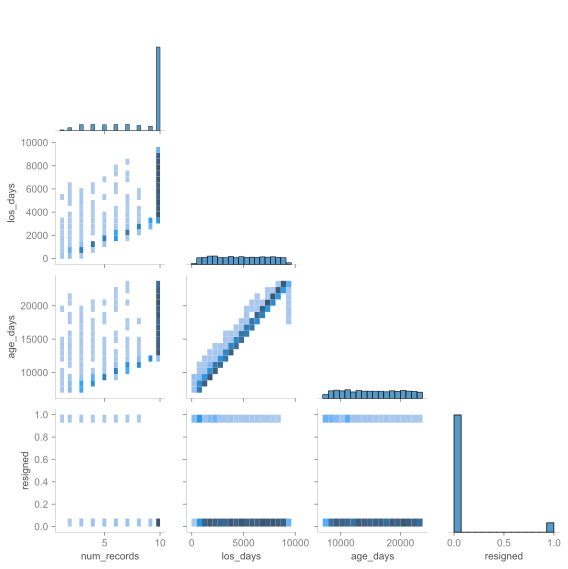

In [619]:
# Assessing potential feature importance for numeric features
df_max.dtypes
numeric = [
'num_records',
'los_days',
'age_days',
'resigned'
]

sns.pairplot(df_max[numeric], kind='hist', height=2, corner=True)

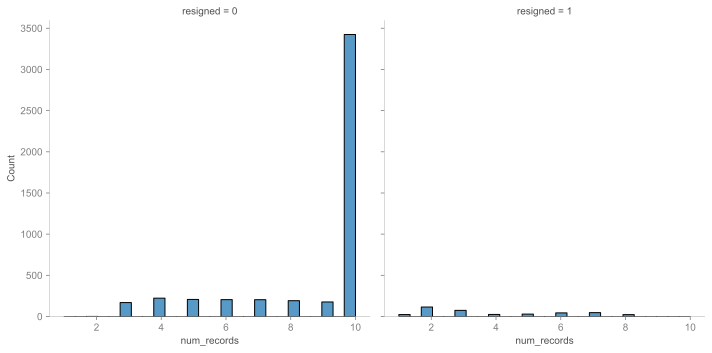

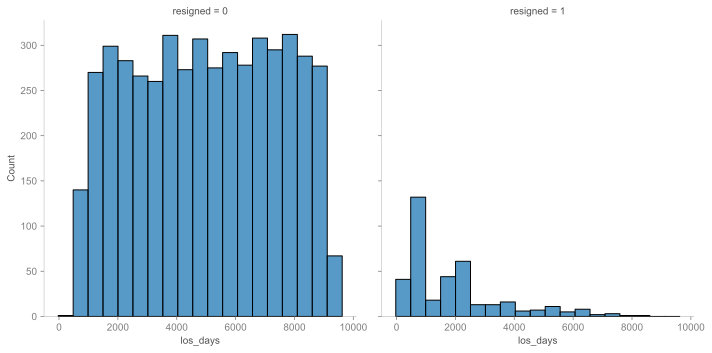

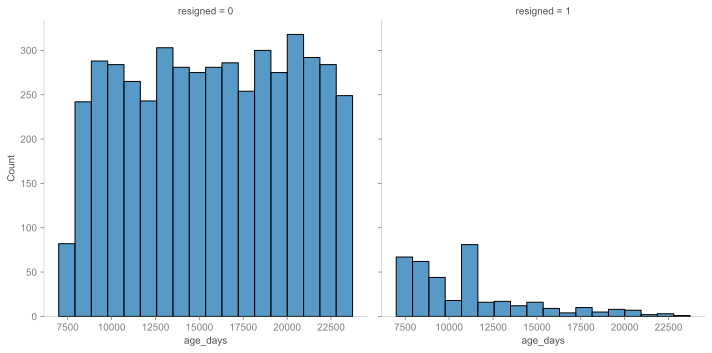

In [620]:
numeric.remove('resigned')

for n in numeric:
    sns.displot(df_max, x=n, col="resigned")

In [562]:
df_max[numeric].head()

auc_dict = {}

for n in numeric:
    auc_dict[f"{n}"] = roc_auc_score(df_max.resigned, df_max[n])    

auc_dict

,num_records,los_days,age_days
9,10.0,9621,22642
19,10.0,9621,21546
29,10.0,9621,22278
39,10.0,9621,20817
49,10.0,9618,21175


{'num_records': 0.06915748455595508,
 'los_days': 0.1429972459119346,
 'age_days': 0.21222832545776082}

From the tables and charts above therefore, it seems likely that younger employees and those with a shorter employment history are more likely to resign than their longer-term counterparts.

Since num_records is really just a count in years of history, it can now be removed.

In [621]:
numeric.remove('num_records')

We can also remove the date fields

In [565]:
df_max.drop([
    'recorddate_key',	'birthdate_key','orighiredate_key',
    'gender_full', 
    # 'age', 'length_of_service',
    ], axis=1, inplace=True)



In [623]:
df_max.columns
categorical

Index(['employeeid', 'recorddate_key', 'birthdate_key', 'orighiredate_key',
       'terminationdate_key', 'age', 'length_of_service', 'city_name',
       'department_name', 'job_title', 'store_name', 'gender_short',
       'gender_full', 'termreason_desc', 'termtype_desc', 'status_year',
       'status', 'business_unit', 'emp_record_idx', 'num_records', 'num_jobs',
       'job_group', 'resigned', 'los_days', 'age_days'],
      dtype='object')

['department_name', 'job_title', 'gender_short', 'business_unit', 'job_group']

In [624]:
# Might be interesting to look at resignation rates per month of the year
df_max['resig_month'] = pd.DatetimeIndex(df_max['terminationdate_key']).month


In [626]:
# Eyeballing data again
df_max.head().T

,9,19,29,39,49
employeeid,1318,1319,1320,1321,1322
recorddate_key,2015-12-31 00:00:00,2015-12-31 00:00:00,2015-12-31 00:00:00,2015-12-31 00:00:00,2015-12-31 00:00:00
birthdate_key,1954-01-03 00:00:00,1957-01-03 00:00:00,1955-01-02 00:00:00,1959-01-02 00:00:00,1958-01-09 00:00:00
orighiredate_key,1989-08-28 00:00:00,1989-08-28 00:00:00,1989-08-28 00:00:00,1989-08-28 00:00:00,1989-08-31 00:00:00
terminationdate_key,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00
age,61,58,60,56,57
length_of_service,26,26,26,26,26
city_name,Vancouver,Vancouver,Vancouver,Vancouver,Vancouver
department_name,Executive,Executive,Executive,Executive,Executive
job_title,CEO,VP Stores,Legal Counsel,VP Human Resources,VP Finance


In [627]:
# Restating categorical 
categorical = ['city_name', 'department_name',
       'job_title', 'store_name', 'gender_short', 
      'status_year',  'business_unit',
       'job_group', 'resig_month']

In [629]:
# Baseline rates for comparison
df_max.resigned.sum()
# Checking...
global_resig_rate = df_max.resigned.mean()
global_attr_rate
global_resig_rate

382

0.074

0.07368827160493827

Now we can examine resignation rates by the categorical features...

resigned          
                      mean sum count
city_name                           
New Westminister  1.000000   4     4
Grand Forks       1.000000   1     1
Dawson Creek      1.000000   1     1
Fort Nelson       1.000000   3     3
Bella Bella       0.187500   3    16
Quesnel           0.136986  10    73
Fort St John      0.128571   9    70
Chilliwack        0.115385  15   130
Port Coquitlam    0.103448   6    58
Williams Lake     0.101449   7    69
North Vancouver   0.092105   7    76
Squamish          0.091954   8    87
Prince George     0.091304  21   230
Surrey            0.089286  15   168
West Vancouver    0.088235   6    68
Nelson            0.085714   3    35
Kelowna           0.084871  23   271
Terrace           0.084615  11   130
Kamloops          0.084444  19   225
Victoria          0.081553  42   515

<AxesSubplot:xlabel='city_name'>

Text(0.5, 1.0, 'Resignation rates by city_name')

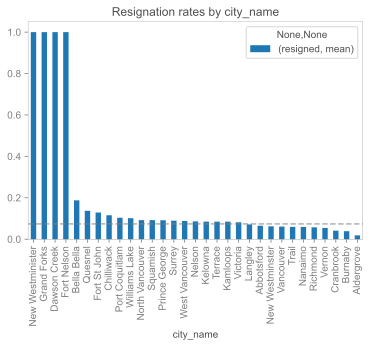

resigned           
                      mean  sum count
department_name                      
HR Technology     1.000000    1     1
Store Management  0.200000    1     5
Customer Service  0.160795  178  1107
Processed Foods   0.074286   52   700
Dairy             0.070640   64   906
Produce           0.036785   27   734
Bakery            0.036765   30   816
Meats             0.032080   29   904
Executive         0.000000    0    10
Recruitment       0.000000    0     1

<AxesSubplot:xlabel='department_name'>

Text(0.5, 1.0, 'Resignation rates by department_name')

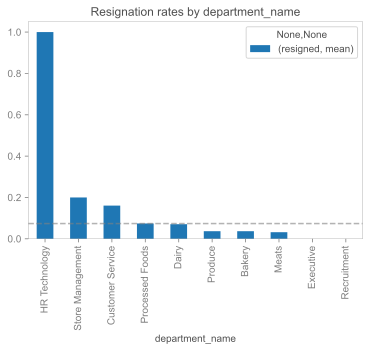

resigned           
                                     mean  sum count
job_title                                           
HRIS Analyst                     1.000000    1     1
Store Manager                    0.200000    1     5
Cashier                          0.163453  178  1089
Shelf Stocker                    0.074671   51   683
Dairy Person                     0.070640   64   906
Processed Foods Manager          0.058824    1    17
Produce Clerk                    0.037396   27   722
Baker                            0.037313   30   804
Meat Cutter                      0.032475   29   893
Exec Assistant, Finance          0.000000    0     1
Exec Assistant, Human Resources  0.000000    0     1
Exec Assistant, Legal Counsel    0.000000    0     1
Exec Assistant, VP Stores        0.000000    0     1
Bakery Manager                   0.000000    0    12
Legal Counsel                    0.000000    0     1
Meats Manager                    0.000000    0    11
Director, Recruitment            0.000000    0     1
Customer Service Manager         0.000000    0    18
Produce Manager                  0.000000    0    12
CHief Information Officer        0.000000    0     1

<AxesSubplot:xlabel='job_title'>

Text(0.5, 1.0, 'Resignation rates by job_title')

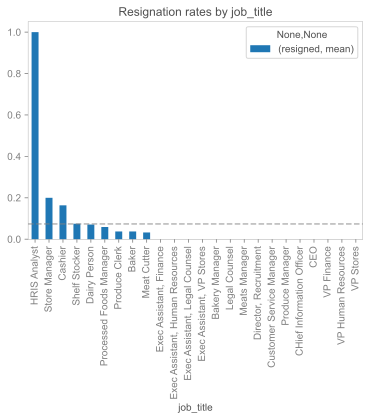

resigned          
                mean sum count
store_name                    
20          1.000000   4     4
9           1.000000   1     1
11          1.000000   3     3
13          1.000000   1     1
3           0.187500   3    16
28          0.136986  10    73
12          0.128571   9    70
6           0.115385  15   130
25          0.103448   6    58
40          0.101449   7    69
44          0.098592  28   284
22          0.092105   7    76
30          0.091954   8    87
26          0.091304  21   230
31          0.089286  15   168
38          0.088235   6    68
19          0.085714   3    35
16          0.084871  23   271
32          0.084615  11   130
15          0.084444  19   225

<AxesSubplot:xlabel='store_name'>

Text(0.5, 1.0, 'Resignation rates by store_name')

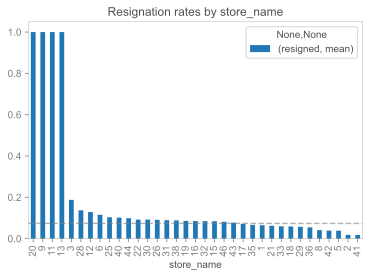

resigned           
                  mean  sum count
gender_short                     
F             0.080808  208  2574
M             0.066667  174  2610

<AxesSubplot:xlabel='gender_short'>

Text(0.5, 1.0, 'Resignation rates by gender_short')

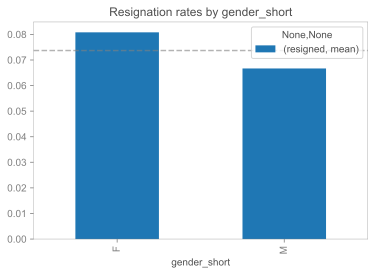

resigned          
                 mean sum count
status_year                    
2006         1.000000  12    12
2007         1.000000  25    25
2008         1.000000  26    26
2010         1.000000  29    29
2011         1.000000  69    69
2012         1.000000  76    76
2014         0.981818  54    55
2013         0.979592  48    49
2009         0.944444  17    18
2015         0.005389  26  4825

<AxesSubplot:xlabel='status_year'>

Text(0.5, 1.0, 'Resignation rates by status_year')

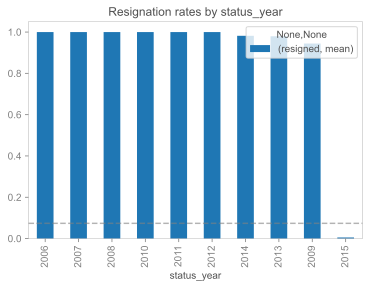

resigned           
                   mean  sum count
business_unit                     
HEADOFFICE     0.083333    1    12
STORES         0.073666  381  5172

<AxesSubplot:xlabel='business_unit'>

Text(0.5, 1.0, 'Resignation rates by business_unit')

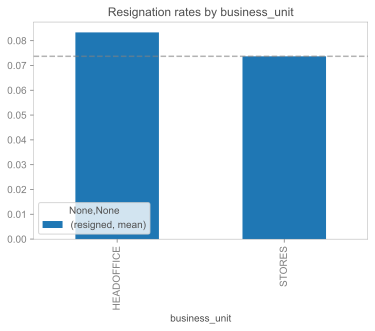

resigned           
                   mean  sum count
job_group                         
Executive      0.200000    1     5
Service Staff  0.074357  379  5097
Manager        0.026667    2    75
C-Suite        0.000000    0     5
Director       0.000000    0     1
Legal          0.000000    0     1

<AxesSubplot:xlabel='job_group'>

Text(0.5, 1.0, 'Resignation rates by job_group')

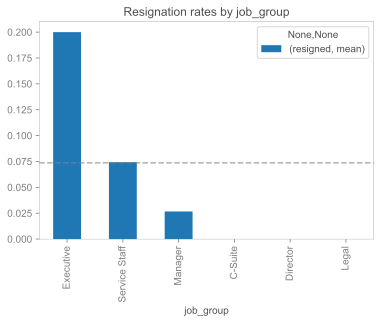

In [631]:
# EDA for resignation rates by the categorical features - each category showing top 20 worst performers.
# Added counts (via sum) in order to quickly discount those category examples with very few employees to begin with.

for c in categorical:
    if c != 'resig_month':
        df_max.groupby(c).agg({'resigned': ['mean', 'sum', 'count']}).sort_values([('resigned', 'mean')], ascending=False).head(20)
        df_max.groupby(c).agg({'resigned': ['mean']}).sort_values([('resigned', 'mean')], ascending=False).plot.bar()
        plt.title(f"Resignation rates by {c}")
        plt.axhline(y=global_resig_rate, color='gray', alpha=0.6,linestyle='--')
        plt.show()

In [571]:
df_max.dtypes

employeeid                      int64
terminationdate_key    datetime64[ns]
age                             int64
length_of_service               int64
city_name                      object
department_name                object
job_title                      object
store_name                      int64
gender_short                   object
termreason_desc                object
termtype_desc                  object
status_year                     int64
status                         object
business_unit                  object
emp_record_idx                float64
num_records                   float64
num_jobs                        int64
job_group                      object
resigned                        int64
los_days                        int64
age_days                        int64
resig_month                     int64
dtype: object

**Results of Attrition Rate by Category**

The graphs and tables above provide the following insights:

* Cashiers are particularly likely to resign, as are employees in Customer Service
* Certain cities such as Bella Bella, Quesnel, Fort St John, Chilliwack, and Port Coquitlam	are particular risk areas - same for stores like 3, 28, 12, 6, 25
* No meaningful difference between male and female resignation rates


Now a closer examination of time-based statistics:

<AxesSubplot:title={'center':'Resignations per Calendar Month'}, xlabel='resig_month'>

<AxesSubplot:title={'center':'Resignations per Calendar Year'}, xlabel='status_year'>

<AxesSubplot:title={'center':'Active Employees per Calendar Year'}, xlabel='status_year'>

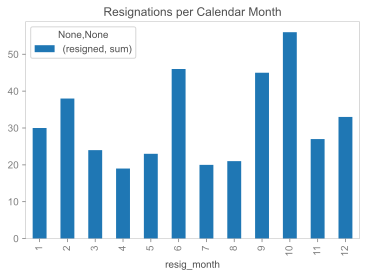

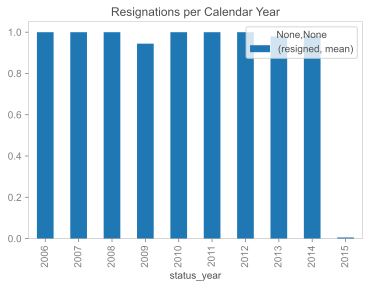

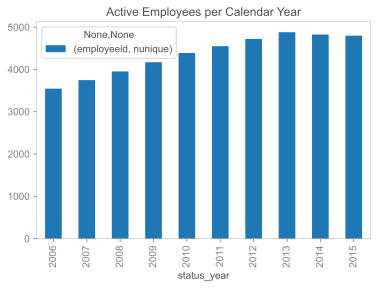

In [633]:
df_max[df_max.resigned==1].groupby('resig_month').agg({'resigned': ['sum']}).plot.bar(title='Resignations per Calendar Month')
df_max.groupby('status_year').agg({'resigned': ['mean']}).plot.bar(title='Resignations per Calendar Year')
df[df.status=='ACTIVE'].groupby('status_year').agg({'employeeid': ['nunique']}).plot.bar(title='Active Employees per Calendar Year')

In [634]:
# Final removal of irrelevant columns
df_max.columns
numeric
categorical = [e for e in categorical if e not in ('status_year', 
# 'store_name', 'city_name',
'status','emp_record_idx','resig_month',)]

categorical


Index(['employeeid', 'recorddate_key', 'birthdate_key', 'orighiredate_key',
       'terminationdate_key', 'age', 'length_of_service', 'city_name',
       'department_name', 'job_title', 'store_name', 'gender_short',
       'gender_full', 'termreason_desc', 'termtype_desc', 'status_year',
       'status', 'business_unit', 'emp_record_idx', 'num_records', 'num_jobs',
       'job_group', 'resigned', 'los_days', 'age_days', 'resig_month'],
      dtype='object')

['los_days', 'age_days']

['city_name',
 'department_name',
 'job_title',
 'store_name',
 'gender_short',
 'business_unit',
 'job_group']

#### Last Check of Data Before Training

In [637]:
df_max[categorical+numeric].dtypes
df_max[categorical+numeric].head(20)
# Store name should not be treated as a numeric data type
df_max.store_name = df_max.store_name.astype('str')

df_max[categorical+numeric].dtypes

city_name          object
department_name    object
job_title          object
store_name         object
gender_short       object
business_unit      object
job_group          object
los_days            int64
age_days            int64
dtype: object

,city_name,department_name,job_title,store_name,gender_short,business_unit,job_group,los_days,age_days
9,Vancouver,Executive,CEO,35,M,HEADOFFICE,C-Suite,9621,22642
19,Vancouver,Executive,VP Stores,35,F,HEADOFFICE,C-Suite,9621,21546
29,Vancouver,Executive,Legal Counsel,35,F,HEADOFFICE,Legal,9621,22278
39,Vancouver,Executive,VP Human Resources,35,M,HEADOFFICE,C-Suite,9621,20817
49,Vancouver,Executive,VP Finance,35,M,HEADOFFICE,C-Suite,9618,21175
59,Vancouver,Executive,"Exec Assistant, VP Stores",35,M,HEADOFFICE,Executive,9618,19714
69,Vancouver,Executive,"Exec Assistant, Legal Counsel",35,F,HEADOFFICE,Executive,9616,18980
79,Vancouver,Executive,CHief Information Officer,35,F,HEADOFFICE,C-Suite,9613,21898
89,Terrace,Store Management,Store Manager,32,F,STORES,Manager,9610,17874
99,Terrace,Meats,Meats Manager,32,F,STORES,Manager,9609,17872


city_name          object
department_name    object
job_title          object
store_name         object
gender_short       object
business_unit      object
job_group          object
los_days            int64
age_days            int64
dtype: object

## Training the Model

### Test/Val/Train Split

In [575]:
# train/validation/test split
target = ['resigned']

df_train_full, df_test = train_test_split(df_max[numeric+categorical+target], test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

y_train = df_train.resigned.values
y_val = df_val.resigned.values
df_train_orig = df_train.copy()
for d in [df_train, df_val, df_test]:
    del d['resigned']

# Checking size
len(df_train), len(df_val), len(df_test)
len(df_train) + len(df_val) + len(df_test) == len(df_max)

# Checking target
y_train[:25]

(3110, 1037, 1037)

True

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

In [576]:
# Quick Data Check after Split
for d in [df_train, df_val, df_test]:
    d.head()

,los_days,age_days,department_name,job_title,gender_short,business_unit,job_group
13412,7306,20085,Produce,Produce Clerk,F,STORES,Service Staff
24726,5613,16879,Bakery,Baker,M,STORES,Service Staff
47581,1099,8331,Customer Service,Cashier,F,STORES,Service Staff
14234,7155,19800,Meats,Meat Cutter,M,STORES,Service Staff
36772,3633,13129,Dairy,Dairy Person,F,STORES,Service Staff


,los_days,age_days,department_name,job_title,gender_short,business_unit,job_group
9037,7964,21331,Meats,Meat Cutter,F,STORES,Service Staff
27226,5183,16065,Bakery,Baker,M,STORES,Service Staff
8423,8057,21507,Processed Foods,Shelf Stocker,F,STORES,Service Staff
25966,5408,16492,Meats,Meat Cutter,M,STORES,Service Staff
37832,3458,12797,Processed Foods,Shelf Stocker,M,STORES,Service Staff


,los_days,age_days,department_name,job_title,gender_short,business_unit,job_group
44962,1983,10004,Customer Service,Cashier,M,STORES,Service Staff
14479,7116,19725,Produce,Produce Clerk,M,STORES,Service Staff
18899,6466,18494,Customer Service,Cashier,F,STORES,Service Staff
21441,6076,17757,Bakery,Baker,M,STORES,Service Staff
21641,6050,17706,Produce,Produce Clerk,M,STORES,Service Staff


In [577]:
def feature_dict(data):
    data = data.fillna(0)
    feat_dict = data.to_dict(orient='records')
    return feat_dict

dv = DictVectorizer(sparse=False)

In [578]:
train_dict = feature_dict(df_train)
val_dict = feature_dict(df_val)

train_dict

[{'los_days': 7306,
  'age_days': 20085,
  'department_name': 'Produce',
  'job_title': 'Produce Clerk',
  'gender_short': 'F',
  'business_unit': 'STORES',
  'job_group': 'Service Staff'},
 {'los_days': 5613,
  'age_days': 16879,
  'department_name': 'Bakery',
  'job_title': 'Baker',
  'gender_short': 'M',
  'business_unit': 'STORES',
  'job_group': 'Service Staff'},
 {'los_days': 1099,
  'age_days': 8331,
  'department_name': 'Customer Service',
  'job_title': 'Cashier',
  'gender_short': 'F',
  'business_unit': 'STORES',
  'job_group': 'Service Staff'},
 {'los_days': 7155,
  'age_days': 19800,
  'department_name': 'Meats',
  'job_title': 'Meat Cutter',
  'gender_short': 'M',
  'business_unit': 'STORES',
  'job_group': 'Service Staff'},
 {'los_days': 3633,
  'age_days': 13129,
  'department_name': 'Dairy',
  'job_title': 'Dairy Person',
  'gender_short': 'F',
  'business_unit': 'STORES',
  'job_group': 'Service Staff'},
 {'los_days': 2432,
  'age_days': 10855,
  'department_name': 'P

In [579]:
dv.fit(train_dict)
dv.transform(train_dict)
dv.get_feature_names()

DictVectorizer(sparse=False)

array([[2.0085e+04, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        7.3060e+03],
       [1.6879e+04, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        5.6130e+03],
       [8.3310e+03, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.0990e+03],
       ...,
       [2.1906e+04, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        8.2670e+03],
       [2.0973e+04, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        7.7750e+03],
       [1.1837e+04, 0.0000e+00, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        2.9500e+03]])

['age_days',
 'business_unit=HEADOFFICE',
 'business_unit=STORES',
 'department_name=Bakery',
 'department_name=Customer Service',
 'department_name=Dairy',
 'department_name=Executive',
 'department_name=Meats',
 'department_name=Processed Foods',
 'department_name=Produce',
 'department_name=Store Management',
 'gender_short=F',
 'gender_short=M',
 'job_group=C-Suite',
 'job_group=Manager',
 'job_group=Service Staff',
 'job_title=Baker',
 'job_title=Bakery Manager',
 'job_title=CEO',
 'job_title=CHief Information Officer',
 'job_title=Cashier',
 'job_title=Customer Service Manager',
 'job_title=Dairy Person',
 'job_title=Meat Cutter',
 'job_title=Meats Manager',
 'job_title=Processed Foods Manager',
 'job_title=Produce Clerk',
 'job_title=Produce Manager',
 'job_title=Shelf Stocker',
 'job_title=Store Manager',
 'job_title=VP Human Resources',
 'job_title=VP Stores',
 'los_days']

In [580]:
X_train = dv.transform(train_dict)
X_train.shape

X_train[:5]
y_train[:5]

X_val = dv.transform(val_dict)

(3110, 33)

array([[2.0085e+04, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 7.3060e+03],
       [1.6879e+04, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 5.6130e+03],
       [8.3310e+03, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000

array([0, 0, 0, 0, 0])

Given that there are far more categorical variables than numeric, it seems sensible to me to try for Decision Tree or related model types such as Random Forest or XGBoost.

### Decision Tree

In [581]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
print(export_text(dt, feature_names=dv.get_feature_names()))

DecisionTreeClassifier(max_depth=3)

|--- los_days <= 706.00
|   |--- age_days <= 7098.50
|   |   |--- class: 0
|   |--- age_days >  7098.50
|   |   |--- department_name=Processed Foods <= 0.50
|   |   |   |--- class: 1
|   |   |--- department_name=Processed Foods >  0.50
|   |   |   |--- class: 1
|--- los_days >  706.00
|   |--- los_days <= 2536.50
|   |   |--- age_days <= 10926.50
|   |   |   |--- class: 0
|   |   |--- age_days >  10926.50
|   |   |   |--- class: 1
|   |--- los_days >  2536.50
|   |   |--- los_days <= 3939.50
|   |   |   |--- class: 0
|   |   |--- los_days >  3939.50
|   |   |   |--- class: 0



In [582]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8847435301410196

In [583]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [584]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8460987137765381

In [585]:
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

DecisionTreeClassifier(max_depth=4)

0.9048891988222532

In [586]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- los_days <= 706.00
|   |--- age_days <= 7098.50
|   |   |--- class: 0
|   |--- age_days >  7098.50
|   |   |--- department_name=Processed Foods <= 0.50
|   |   |   |--- class: 1
|   |   |--- department_name=Processed Foods >  0.50
|   |   |   |--- age_days <= 9048.50
|   |   |   |   |--- class: 1
|   |   |   |--- age_days >  9048.50
|   |   |   |   |--- class: 0
|--- los_days >  706.00
|   |--- los_days <= 2536.50
|   |   |--- age_days <= 10926.50
|   |   |   |--- los_days <= 905.00
|   |   |   |   |--- class: 0
|   |   |   |--- los_days >  905.00
|   |   |   |   |--- class: 0
|   |   |--- age_days >  10926.50
|   |   |   |--- los_days <= 2456.50
|   |   |   |   |--- class: 1
|   |   |   |--- los_days >  2456.50
|   |   |   |   |--- class: 0
|   |--- los_days >  2536.50
|   |   |--- los_days <= 3939.50
|   |   |   |--- age_days <= 13802.50
|   |   |   |   |--- class: 0
|   |   |   |--- age_days >  13802.50
|   |   |   |   |--- class: 1
|   |   |--- los_days >  3939.50
|   |   |   

#### Parameter Tuning

In [587]:
scores = []
for m in range(1, 16):
    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s,)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((m, s, auc))


DecisionTreeClassifier(max_depth=1)

DecisionTreeClassifier(max_depth=1, min_samples_leaf=5)

DecisionTreeClassifier(max_depth=1, min_samples_leaf=10)

DecisionTreeClassifier(max_depth=1, min_samples_leaf=15)

DecisionTreeClassifier(max_depth=1, min_samples_leaf=20)

DecisionTreeClassifier(max_depth=1, min_samples_leaf=50)

DecisionTreeClassifier(max_depth=1, min_samples_leaf=100)

DecisionTreeClassifier(max_depth=1, min_samples_leaf=200)

DecisionTreeClassifier(max_depth=2)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=5)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=10)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=15)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=20)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=50)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=100)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=200)

DecisionTreeClassifier(max_depth=3)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=10)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=15)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=20)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=50)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=100)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=200)

DecisionTreeClassifier(max_depth=4)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=5)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=10)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=15)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=20)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=50)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=100)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=200)

DecisionTreeClassifier(max_depth=5)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=15)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=20)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=50)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=100)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=200)

DecisionTreeClassifier(max_depth=6)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=5)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=10)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=20)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=50)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=100)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=200)

DecisionTreeClassifier(max_depth=7)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=5)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=10)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=15)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=20)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=50)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=100)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=200)

DecisionTreeClassifier(max_depth=8)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=5)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=10)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=15)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=20)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=50)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=100)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=200)

DecisionTreeClassifier(max_depth=9)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=5)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=10)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=15)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=20)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=50)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=100)

DecisionTreeClassifier(max_depth=9, min_samples_leaf=200)

DecisionTreeClassifier(max_depth=10)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=15)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=20)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=100)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=200)

DecisionTreeClassifier(max_depth=11)

DecisionTreeClassifier(max_depth=11, min_samples_leaf=5)

DecisionTreeClassifier(max_depth=11, min_samples_leaf=10)

DecisionTreeClassifier(max_depth=11, min_samples_leaf=15)

DecisionTreeClassifier(max_depth=11, min_samples_leaf=20)

DecisionTreeClassifier(max_depth=11, min_samples_leaf=50)

DecisionTreeClassifier(max_depth=11, min_samples_leaf=100)

DecisionTreeClassifier(max_depth=11, min_samples_leaf=200)

DecisionTreeClassifier(max_depth=12)

DecisionTreeClassifier(max_depth=12, min_samples_leaf=5)

DecisionTreeClassifier(max_depth=12, min_samples_leaf=10)

DecisionTreeClassifier(max_depth=12, min_samples_leaf=15)

DecisionTreeClassifier(max_depth=12, min_samples_leaf=20)

DecisionTreeClassifier(max_depth=12, min_samples_leaf=50)

DecisionTreeClassifier(max_depth=12, min_samples_leaf=100)

DecisionTreeClassifier(max_depth=12, min_samples_leaf=200)

DecisionTreeClassifier(max_depth=13)

DecisionTreeClassifier(max_depth=13, min_samples_leaf=5)

DecisionTreeClassifier(max_depth=13, min_samples_leaf=10)

DecisionTreeClassifier(max_depth=13, min_samples_leaf=15)

DecisionTreeClassifier(max_depth=13, min_samples_leaf=20)

DecisionTreeClassifier(max_depth=13, min_samples_leaf=50)

DecisionTreeClassifier(max_depth=13, min_samples_leaf=100)

DecisionTreeClassifier(max_depth=13, min_samples_leaf=200)

DecisionTreeClassifier(max_depth=14)

DecisionTreeClassifier(max_depth=14, min_samples_leaf=5)

DecisionTreeClassifier(max_depth=14, min_samples_leaf=10)

DecisionTreeClassifier(max_depth=14, min_samples_leaf=15)

DecisionTreeClassifier(max_depth=14, min_samples_leaf=20)

DecisionTreeClassifier(max_depth=14, min_samples_leaf=50)

DecisionTreeClassifier(max_depth=14, min_samples_leaf=100)

DecisionTreeClassifier(max_depth=14, min_samples_leaf=200)

DecisionTreeClassifier(max_depth=15)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=5)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=10)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=15)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=50)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=100)

DecisionTreeClassifier(max_depth=15, min_samples_leaf=200)

In [588]:
df_scores = pd.DataFrame(scores, columns=['Max Depth', 'Min Samples', 'AUC'])

df_scores.head()
df_scores.tail()

df_scores['AUC'].max()

df_scores[df_scores['AUC'] == df_scores['AUC'].max()]

,Max Depth,Min Samples,AUC
0,1,1,0.722222
1,1,5,0.722222
2,1,10,0.722222
3,1,15,0.722222
4,1,20,0.722222


,Max Depth,Min Samples,AUC
115,15,15,0.965501
116,15,20,0.962705
117,15,50,0.944457
118,15,100,0.937987
119,15,200,0.913542


0.9793442326566455

,Max Depth,Min Samples,AUC
49,7,5,0.979344


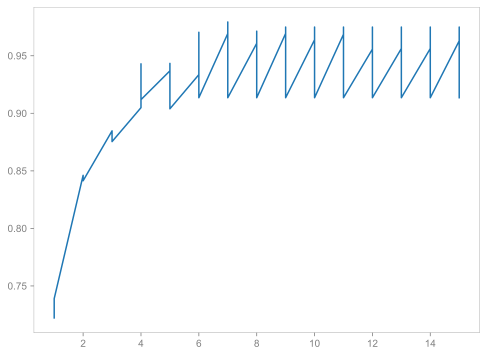

In [589]:
fig = plt.figure(figsize=(8, 6))

plt.plot(df_scores['Max Depth'], df_scores.AUC)

#### Checking Most Optimal Model

In [590]:
dt = DecisionTreeClassifier(max_depth=8, min_samples_leaf=20)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_dt)

print(export_text(dt, feature_names=dv.get_feature_names()))

DecisionTreeClassifier(max_depth=8, min_samples_leaf=20)

0.9626401157084561

|--- los_days <= 706.00
|   |--- los_days <= 517.00
|   |   |--- class: 1
|   |--- los_days >  517.00
|   |   |--- class: 1
|--- los_days >  706.00
|   |--- los_days <= 2536.50
|   |   |--- age_days <= 10926.50
|   |   |   |--- los_days <= 905.00
|   |   |   |   |--- age_days <= 7897.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- age_days >  7897.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- los_days >  905.00
|   |   |   |   |--- age_days <= 10422.50
|   |   |   |   |   |--- los_days <= 1264.50
|   |   |   |   |   |   |--- age_days <= 8491.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- age_days >  8491.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- los_days >  1264.50
|   |   |   |   |   |   |--- age_days <= 10245.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- age_days >  10245.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- age_days >  10422.50
|   |   |   |   |   |--- lo

[Text(98.2454268292683, 205.35999999999999, 'X[32] <= 706.0\ngini = 0.136\nsamples = 3110\nvalue = [2881, 229]'),
 Text(52.05731707317073, 181.2, 'X[32] <= 517.0\ngini = 0.041\nsamples = 96\nvalue = [2, 94]'),
 Text(43.891463414634146, 157.04, 'gini = 0.147\nsamples = 25\nvalue = [2, 23]'),
 Text(60.22317073170732, 157.04, 'gini = 0.0\nsamples = 71\nvalue = [0, 71]'),
 Text(144.43353658536586, 181.2, 'X[32] <= 2536.5\ngini = 0.086\nsamples = 3014\nvalue = [2879, 135]'),
 Text(76.5548780487805, 157.04, 'X[0] <= 10926.5\ngini = 0.208\nsamples = 686\nvalue = [605, 81]'),
 Text(38.78780487804878, 132.88, 'X[32] <= 905.0\ngini = 0.069\nsamples = 611\nvalue = [589, 22]'),
 Text(16.33170731707317, 108.72, 'X[0] <= 7897.5\ngini = 0.219\nsamples = 64\nvalue = [56, 8]'),
 Text(8.165853658536586, 84.56, 'gini = 0.0\nsamples = 44\nvalue = [44, 0]'),
 Text(24.49756097560976, 84.56, 'gini = 0.48\nsamples = 20\nvalue = [12, 8]'),
 Text(61.24390243902439, 108.72, 'X[0] <= 10422.5\ngini = 0.05\nsamples

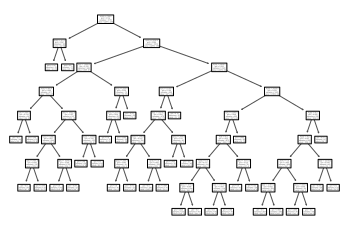

In [591]:
tree.plot_tree(dt)

<Figure size 360x360 with 0 Axes>

(-0.02, 1.02)

(-0.02, 1.02)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC curve')

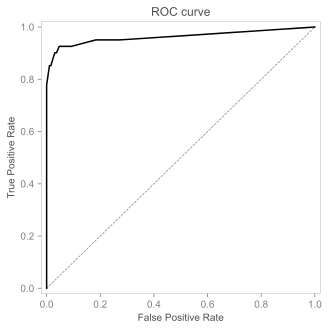

In [592]:
fpr, tpr, _ = roc_curve(y_val, y_pred_dt)

plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

In [593]:
list(zip(dv.feature_names_, dt.feature_importances_))

[('age_days', 0.38490239965904893),
 ('business_unit=HEADOFFICE', 0.0),
 ('business_unit=STORES', 0.0),
 ('department_name=Bakery', 0.0),
 ('department_name=Customer Service', 0.0),
 ('department_name=Dairy', 0.0),
 ('department_name=Executive', 0.0),
 ('department_name=Meats', 0.0011248847466089969),
 ('department_name=Processed Foods', 0.0),
 ('department_name=Produce', 0.0),
 ('department_name=Store Management', 0.0),
 ('gender_short=F', 0.0),
 ('gender_short=M', 0.0),
 ('job_group=C-Suite', 0.0),
 ('job_group=Manager', 0.00010157362698881864),
 ('job_group=Service Staff', 0.0),
 ('job_title=Baker', 0.00016141727121802465),
 ('job_title=Bakery Manager', 0.0),
 ('job_title=CEO', 0.0),
 ('job_title=CHief Information Officer', 0.0),
 ('job_title=Cashier', 0.00018241440917921088),
 ('job_title=Customer Service Manager', 0.0),
 ('job_title=Dairy Person', 0.00012042379764908056),
 ('job_title=Meat Cutter', 0.0),
 ('job_title=Meats Manager', 0.0),
 ('job_title=Processed Foods Manager', 0.0

### Random Forest

In [594]:
rf_scores = []

depths = [10, 15, 20, 25]

for d in depths:
    for r in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=r, random_state=1, n_jobs=-1, max_depth=d)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        auc = roc_auc_score(y_val, y_pred)
        rf_scores.append((m, s, auc))

RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=10, n_estimators=20, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=10, n_estimators=30, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=10, n_estimators=40, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=10, n_estimators=50, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=10, n_estimators=60, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=10, n_estimators=70, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=10, n_estimators=90, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=10, n_estimators=110, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=10, n_estimators=120, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=10, n_estimators=130, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=10, n_estimators=140, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=10, n_estimators=160, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=10, n_estimators=170, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=10, n_estimators=180, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=10, n_estimators=190, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=10, n_estimators=200, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=15, n_estimators=10, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=15, n_estimators=20, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=15, n_estimators=30, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=15, n_estimators=40, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=15, n_estimators=50, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=15, n_estimators=60, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=15, n_estimators=70, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=15, n_estimators=80, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=15, n_estimators=90, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=15, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=15, n_estimators=110, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=15, n_estimators=120, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=15, n_estimators=130, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=15, n_estimators=140, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=15, n_estimators=150, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=15, n_estimators=160, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=15, n_estimators=170, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=15, n_estimators=180, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=15, n_estimators=190, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=15, n_estimators=200, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=20, n_estimators=20, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=20, n_estimators=30, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=20, n_estimators=40, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=20, n_estimators=50, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=20, n_estimators=60, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=20, n_estimators=70, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=20, n_estimators=80, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=20, n_estimators=90, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=20, n_estimators=110, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=20, n_estimators=120, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=20, n_estimators=130, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=20, n_estimators=140, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=20, n_estimators=150, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=20, n_estimators=160, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=20, n_estimators=170, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=20, n_estimators=180, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=20, n_estimators=190, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=20, n_estimators=200, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=25, n_estimators=10, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=25, n_estimators=20, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=25, n_estimators=30, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=25, n_estimators=40, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=25, n_estimators=50, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=25, n_estimators=60, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=25, n_estimators=70, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=25, n_estimators=80, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=25, n_estimators=90, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=25, n_jobs=-1, random_state=1)

RandomForestClassifier(max_depth=25, n_estimators=110, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=25, n_estimators=120, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=25, n_estimators=130, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=25, n_estimators=140, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=25, n_estimators=150, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=25, n_estimators=160, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=25, n_estimators=170, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=25, n_estimators=180, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=25, n_estimators=190, n_jobs=-1,
                       random_state=1)

RandomForestClassifier(max_depth=25, n_estimators=200, n_jobs=-1,
                       random_state=1)

In [595]:
df_rf_scores = pd.DataFrame(rf_scores, columns=['Max_Depth', 'No_Estimators', 'AUC'])
df_rf_scores.head(20)
df_rf_scores.tail(12)


,Max_Depth,No_Estimators,AUC
0,15,200,0.850806
1,15,200,0.850806
2,15,200,0.856979
3,15,200,0.850806
4,15,200,0.851852
5,15,200,0.851329
6,15,200,0.851852
7,15,200,0.845679
8,15,200,0.851329
9,15,200,0.845156


,Max_Depth,No_Estimators,AUC
68,15,200,0.881670
69,15,200,0.881670
70,15,200,0.881670
71,15,200,0.887843
72,15,200,0.887843
73,15,200,0.881670
74,15,200,0.881670
75,15,200,0.881670
76,15,200,0.881670
77,15,200,0.881670


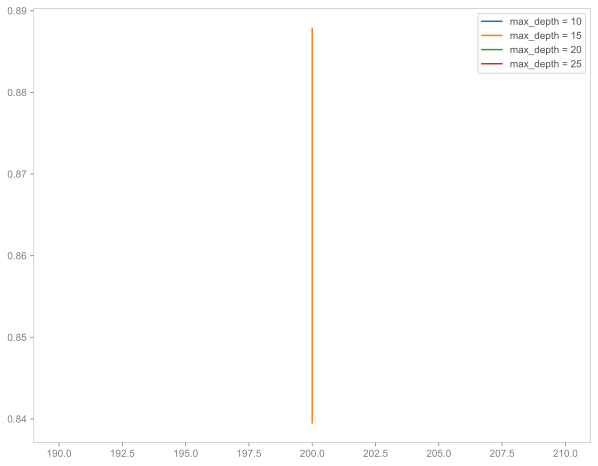

In [596]:
fig = plt.figure(figsize=(10, 8))

for d in depths:
    df_sub = df_rf_scores[df_rf_scores.Max_Depth==d]
    plt.plot(df_sub.No_Estimators, df_sub.AUC, label=f'max_depth = {d}')

plt.legend()

So far it appears that the Decision Tree is performing better than Random Forest.

### XGBoost

In [597]:
features = dv.get_feature_names()
features

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

['age_days',
 'business_unit=HEADOFFICE',
 'business_unit=STORES',
 'department_name=Bakery',
 'department_name=Customer Service',
 'department_name=Dairy',
 'department_name=Executive',
 'department_name=Meats',
 'department_name=Processed Foods',
 'department_name=Produce',
 'department_name=Store Management',
 'gender_short=F',
 'gender_short=M',
 'job_group=C-Suite',
 'job_group=Manager',
 'job_group=Service Staff',
 'job_title=Baker',
 'job_title=Bakery Manager',
 'job_title=CEO',
 'job_title=CHief Information Officer',
 'job_title=Cashier',
 'job_title=Customer Service Manager',
 'job_title=Dairy Person',
 'job_title=Meat Cutter',
 'job_title=Meats Manager',
 'job_title=Processed Foods Manager',
 'job_title=Produce Clerk',
 'job_title=Produce Manager',
 'job_title=Shelf Stocker',
 'job_title=Store Manager',
 'job_title=VP Human Resources',
 'job_title=VP Stores',
 'los_days']

In [598]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [599]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    
    
    'objective': 'binary:logistic',
    'nthread': 8,

    'eval_metric': 'auc',
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=10)

In [600]:
print(output)

[0]	train-auc:0.84903	val-auc:0.87694
[10]	train-auc:0.99555	val-auc:0.98850
[20]	train-auc:0.99987	val-auc:0.99943
[30]	train-auc:0.99993	val-auc:0.99967
[40]	train-auc:0.99996	val-auc:0.99963
[50]	train-auc:0.99997	val-auc:0.99964
[60]	train-auc:0.99999	val-auc:0.99970
[70]	train-auc:0.99999	val-auc:0.99966
[80]	train-auc:0.99999	val-auc:0.99965
[90]	train-auc:0.99999	val-auc:0.99950
[99]	train-auc:0.99999	val-auc:0.99948



In [601]:
def parse_xgb_output(output):
    tree = []
    aucs_train = []
    aucs_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        tree.append(it)
        aucs_train.append(train)
        aucs_val.append(val)

    return tree, aucs_train, aucs_val

In [602]:
tree, _, rmse_val_eta_03 = parse_xgb_output(output)
print('Scores for 0.3:')
print(min(rmse_val_eta_03))
print(min(zip(rmse_val_eta_03, tree)))

Scores for 0.3:
0.87694
(0.87694, 0)


In [603]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    
    
    'objective': 'binary:logistic',
    'nthread': 8,

    'eval_metric': 'auc',
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=10)

In [604]:
tree, _, rmse_val_eta_01 = parse_xgb_output(output)
print('Scores for 0.1:')
print(min(rmse_val_eta_01))
print(min(zip(rmse_val_eta_01, tree)))

Scores for 0.1:
0.87694
(0.87694, 0)


In [605]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,

    
    
    'objective': 'binary:logistic',
    'nthread': 8,

    'eval_metric': 'auc',
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=10)

In [606]:
tree, _, rmse_val_eta_01 = parse_xgb_output(output)
print('Scores for 0.01:')
print(min(rmse_val_eta_01))
print(min(zip(rmse_val_eta_01, tree)))

Scores for 0.01:
0.87694
(0.87694, 0)


In [607]:
%%capture output

xgb_params = {
    'eta': 0.5, 
    'max_depth': 6,
    'min_child_weight': 1,

    
    
    'objective': 'binary:logistic',
    'nthread': 8,

    'eval_metric': 'auc',
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=10)

In [608]:
tree, _, rmse_val_eta_01 = parse_xgb_output(output)
print('Scores for 0.5:')
print(min(rmse_val_eta_01))
print(min(zip(rmse_val_eta_01, tree)))

Scores for 0.5:
0.87694
(0.87694, 0)


So at this point, much to my surprise, it appears that the most performant model is Decision Tree.  We will therefore put this into production.

## Caveats and suggested further steps

## The End